# 1000 Jupyter Notebooks
This notebook analyzes 1000 (really 1020) Jupyter Notebooks [scraped from GitHub](github_scraping.ipynb) on June 26, 2017.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Import Data

In [2]:
df = pd.read_csv('data/recent_notebooks.csv')
del df['Unnamed: 0']
print(df.shape)
df.head()

(1020, 5)


,html_url,name,path,raw_url,download_index
0,https://github.com/ericschulz/compforca/blob/d...,Analysis.ipynb,Data analysis/Analysis.ipynb,https://raw.githubusercontent.com/ericschulz/c...,0
1,https://github.com/huang12zheng/jupyter/blob/c...,SetEnv.ipynb,python_study/SetEnv.ipynb,https://raw.githubusercontent.com/huang12zheng...,1
2,https://github.com/bukosabino/btctrading/blob/...,xgboost.ipynb,xgboost.ipynb,https://raw.githubusercontent.com/bukosabino/b...,2
3,https://github.com/bukosabino/btctrading/blob/...,Ensembles.ipynb,Ensembles.ipynb,https://raw.githubusercontent.com/bukosabino/b...,3
4,https://github.com/BenjiDa/Flowstress/blob/ff9...,Compile_code.ipynb,Compile_code.ipynb,https://raw.githubusercontent.com/BenjiDa/Flow...,4


## Calculate Notebook Stats

For each notebook, I'd like to first know a couple basic stats like nbformat, kernel, number and type of cells, lines of code, and so on. I will pull this information from the notebooks themselves.

I will also want to get two additional bits of information from the url, namely the user and repository

In [3]:
# get github user and repository containing the notebook from the url
splits = df['html_url'].str.split('/')

df['user_name'] = splits.str[3]
df['repo_name'] = splits.str[4]

In [4]:
# columns for notebook size
df["byte_size"] = None
df["num_cells"] = None
df["num_markdown_cells"] = None
df["num_code_cells"] = None
df["num_raw_cells"] = None
df["markdown_words"] = None
df["code_lines"] = None

# ... for code cell outputs
df["num_display_data"] = None
df["num_execute_result"] = None
df["num_error"] = None

# ... nbformat and the kernel
df["nb_format"] = None
df["nb_format_minor"] = None
df["kernel_lang"] = None
df["kernel_name"] = None

In [5]:
# calculate stats and get metadata for all 1020 notebooks
for i in range(0, 1020):
    # track progress
    if i % 100 == 0:
        print(i)
    
    # Load file
    f = "data/raw_notebooks/nb%s.json" % i
    byte_size = os.path.getsize(f)

    with open(f) as data_file:    
        # load json file
        try:
            data = json.load(data_file)
        except:
            continue
        
        # initialize counters
        code_lines = 0
        markdown_words = 0

        num_code_cells = 0
        num_markdown_cells = 0
        num_raw_cells = 0

        num_display_data = 0
        num_execute_result = 0
        num_error = 0

        # get nbformat and kernel metadata, which may not be there
        try:
            nb_format = data['nbformat']
            nb_format_minor = data['nbformat_minor']
        except:
            nb_format = None
            nb_format_minor = None
            
        try:
            kernel_lang = data['metadata']['kernelspec']['language']
            kernel_name = data['metadata']['kernelspec']['name']                
        except:
            kernel_lang = None
            kernel_name = None
            
        # get cells, which are stored differently depending on the nbformat version
        if nb_format >= 4:
            cells = data['cells']
        else:
            cells = data['worksheets'][0]['cells']

        num_cells = len(cells)

        for c in cells:

            # markdown cells
            if c['cell_type'] in ['markdown','heading']:
                num_markdown_cells += 1
                for l in c['source']:                
                    markdown_words += len(l.split())                

            # code cells
            elif c['cell_type'] == "code":
                num_code_cells += 1
                if 'input' in c.keys():
                    code_lines += len(c['input'])
                elif 'source' in c.keys():
                    code_lines += len(c['source'])
                else:
                    print("Could not find code cell source")

                # count outputs
                for o in c['outputs']:
                    if o['output_type'] == 'display_data':
                        num_display_data += 1
                    elif o['output_type'] in ['execute_result', 'pyout']:
                        num_execute_result += 1
                    elif o['output_type'] == 'error':
                        num_error += 1

            # raw cells
            elif c['cell_type'] == 'raw':
                num_raw_cells += 1

        # and store all our values, this may have been better as a vector operation
        df.set_value(i, 'byte_size', byte_size)
        df.set_value(i, 'nb_format', nb_format)
        df.set_value(i, 'nb_format_minor', nb_format_minor)
        df.set_value(i, 'kernel_lang', kernel_lang)
        df.set_value(i, 'kernel_name', kernel_name)
        df.set_value(i, 'num_cells', num_cells)
        df.set_value(i, 'num_markdown_cells', num_markdown_cells)
        df.set_value(i, 'num_code_cells', num_code_cells)
        df.set_value(i, 'num_raw_cells', num_raw_cells)
        df.set_value(i, 'markdown_words', markdown_words)
        df.set_value(i, 'code_lines', code_lines)
        df.set_value(i, 'num_display_data', num_display_data)
        df.set_value(i, 'num_execute_result', num_execute_result)
        df.set_value(i, 'num_error', num_error)

0
100
200
300
400
500
600
700
800
900
1000


## Cleaning

And after some hacky scraping, I think I should have values for most of my measures. Now to check. First off, how many null values do I have? And what are the notebooks that are causing issues?

Two notebooks (743, 842), did not exist anymore (likely taken down between the search query and scraping the full notebook). Two were nbformat version 3.0, and did not have a kernel spec, and several others do not have kernel metadata. Overall, fairly full dataset.

In [6]:
df[df.isnull().any(axis=1)]

,html_url,name,path,raw_url,download_index,user_name,repo_name,byte_size,num_cells,num_markdown_cells,...,num_raw_cells,markdown_words,code_lines,num_display_data,num_execute_result,num_error,nb_format,nb_format_minor,kernel_lang,kernel_name
49,https://github.com/vsmolyakov/experiments_with...,stock_clusters.ipynb,chp04/stock_clusters.ipynb,https://raw.githubusercontent.com/vsmolyakov/e...,49,vsmolyakov,experiments_with_python,124172,19,9,...,0,172,111,3,1,0,3,0,None,None
695,https://github.com/Closure-Man/DiscreteNoteboo...,Module2_Boolean_Logic_Basic-checkpoint.ipynb,Discrete/.ipynb_checkpoints/Module2_Boolean_Lo...,https://raw.githubusercontent.com/Closure-Man/...,695,Closure-Man,DiscreteNotebooks,72,0,0,...,0,0,0,0,0,0,4,2,None,None
743,https://github.com/CPapadim/onboarding-npd/blo...,demo-notebook.ipynb,demo-notebook.ipynb,https://raw.githubusercontent.com/CPapadim/onb...,743,CPapadim,onboarding-npd,None,None,None,...,None,None,None,None,None,None,None,None,None,None
746,https://github.com/jmborr/confinedBSA/blob/bf1...,confinedBSA.ipynb,confinedBSA.ipynb,https://raw.githubusercontent.com/jmborr/confi...,746,jmborr,confinedBSA,42660,17,16,...,0,3033,0,0,0,0,3,0,None,None
755,https://github.com/wino6687/SWE_TB/blob/824428...,Down_Sampling_NetCDF-checkpoint.ipynb,.ipynb_checkpoints/Down_Sampling_NetCDF-checkp...,https://raw.githubusercontent.com/wino6687/SWE...,755,wino6687,SWE_TB,72,0,0,...,0,0,0,0,0,0,4,1,None,None
842,https://github.com/ggoedde/ml_mini_projects/bl...,neural_net_from_scratch.ipynb,neural_net_from_scratch/neural_net_from_scratc...,https://raw.githubusercontent.com/ggoedde/ml_m...,842,ggoedde,ml_mini_projects,None,None,None,...,None,None,None,None,None,None,None,None,None,None
912,https://github.com/ishanpanwar09/Projects/blob...,Untitled3-checkpoint.ipynb,Py-ImageClassification(Clarifai_and Tensorflow...,https://raw.githubusercontent.com/ishanpanwar0...,912,ishanpanwar09,Projects,72,0,0,...,0,0,0,0,0,0,4,1,None,None
913,https://github.com/ishanpanwar09/Projects/blob...,Untitled2-checkpoint.ipynb,Py-ImageClassification(Clarifai_and Tensorflow...,https://raw.githubusercontent.com/ishanpanwar0...,913,ishanpanwar09,Projects,72,0,0,...,0,0,0,0,0,0,4,1,None,None
914,https://github.com/ishanpanwar09/Projects/blob...,Untitled1-checkpoint.ipynb,Py-ImageClassification(Clarifai_and Tensorflow...,https://raw.githubusercontent.com/ishanpanwar0...,914,ishanpanwar09,Projects,72,0,0,...,0,0,0,0,0,0,4,1,None,None
977,https://github.com/Bulochkin/tensorflow_pack/b...,2_getting_started.ipynb,tensorflow/tools/docker/notebooks/2_getting_st...,https://raw.githubusercontent.com/Bulochkin/te...,977,Bulochkin,tensorflow_pack,164559,25,16,...,0,1242,220,6,2,0,4,0,None,None


In [7]:
# only 17 notebooks missing any data, mostly the kernel
df_clean = df.dropna()
df_clean.shape

(1003, 21)

## Analysis

### Users and Repos

According to this analysis, There are only 134 users and 138 repos contributing to the 1020 most recently index notebooks on GitHub. By far and away matplotlib's devdocs is the largest contributor with over half the notebooks.

It looks like Matplotlib's development team generated a lot of the notebooks we scraped. For the rest of the analysis, we will look at how removing this group affects our measures.

In [8]:
df['user_name'].value_counts()

matplotlib              556
datumsays                82
deepakgupta1313          41
ishanpanwar09            40
hungjinh                 37
KnittelK                 14
Closure-Man              12
Bulochkin                10
wino6687                 10
giuliavezzani             6
TWellman                  6
johnnycs                  5
elirex                    5
mcscruf61                 5
jmern3250                 5
fonnesbeck                5
gloryfromca               4
HuangYiran                4
bringingjoy               4
lesley2958                4
NSLS-II                   4
c-ern                     4
ds17                      3
mslovett21                3
betamore                  3
ikizhvatov                3
abhisekswain              3
MsToT                     3
LingxB                    2
annacbf                   2
                       ... 
andrewjsiu                1
ericschulz                1
doudoujay                 1
lanking520                1
eds-uga             

In [9]:
df['repo_name'].value_counts()

devdocs                         556
testing_dir                      82
deep-learning                    41
Projects                         40
baryon_proj                      37
BH-collisional-outcomes          14
DiscreteNotebooks                12
SWE_TB                           10
tensorflow_pack                  10
cs231n-assignements               6
dengue-prediction                 5
ml-practice                       5
EE207                             5
ngcm_sklearn_2017                 5
MAE4120                           5
exceltest                         4
tutorial-docker                   4
Tensorflow_formatted              4
python_data_analysis              4
fakenewsjedi                      4
adS17                             3
Vendor-AI                         3
USGS_BCB-NPN-Dev-Space            3
erddap_scibase_synthesis          3
Indexing-Tools-Project            3
jlsca-tutorials                   3
laughing-guide                    3
reptiles_gh                 

In [10]:
# removing matplotlib cuts the dataset in half
df_no_matplotlib = df_clean[df_clean.user_name != 'matplotlib']
df_no_matplotlib.shape

(447, 21)

### nbformat
Most notebooks are nbformat 4.0, followed by 4.2 and 4.1

In [11]:
df['nb_format'].value_counts()

4    1016
3       2
Name: nb_format, dtype: int64

In [12]:
df['nb_format_minor'].value_counts()

0    719
2    191
1    108
Name: nb_format_minor, dtype: int64

### Kernel
And python (python3 to be exact) is by far the most used kernel. Only 1% in this sample used anything else. However, we'd need to check the magics to see if notebooks are calling other types of code (e.g. %%bash)

In [13]:
df['kernel_lang'].value_counts()

python    992
julia       7
R           2
bash        2
Name: kernel_lang, dtype: int64

In [14]:
df['kernel_name'].value_counts()

python3                       816
python2                       112
Python [Root]                  29
conda-root-py                  10
conda-env-ipykernel_py2-py      9
julia-0.6                       6
conda-env-ipykernel_35-py       4
django_extensions               2
python3.5                       2
conda-env-PDSH-py               2
Python [py27]                   2
bash                            2
ir                              1
Python [py3]                    1
python_env                      1
julia-0.5                       1
conda-env-py35-r                1
tensorflow-gpu-1.2              1
tensorflow-cpu                  1
Name: kernel_name, dtype: int64

### Filesize
It is hard to tell with this small of a dataset, but plotted on a log scale it almost seems like we have a normal distribution around 100,000 bytes, once we remove matplotlib's small files.

The blue is the full dataset, and the green is with matplotlib removed.

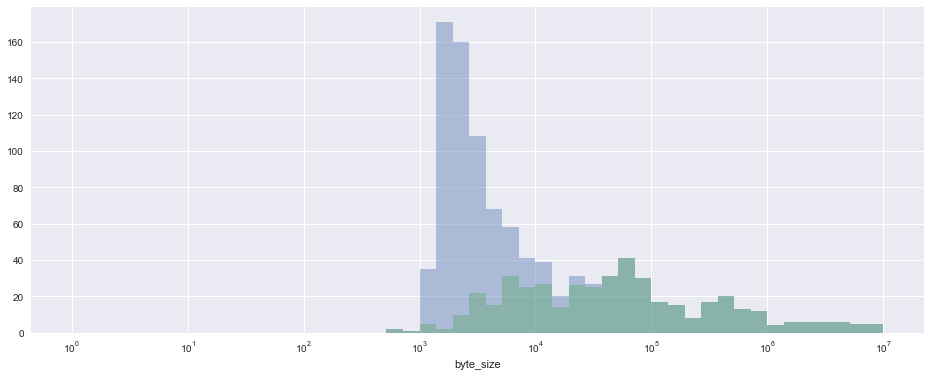

In [15]:
fig1, ax1 = plt.subplots(figsize=(16, 6))
ax1.set_xscale('log')

sns.distplot(df_clean['byte_size'], bins=np.logspace(0, 7, 50), kde=False, ax = ax1)
sns.distplot(df_no_matplotlib['byte_size'], bins=np.logspace(0, 7, 50), kde=False, ax = ax1)

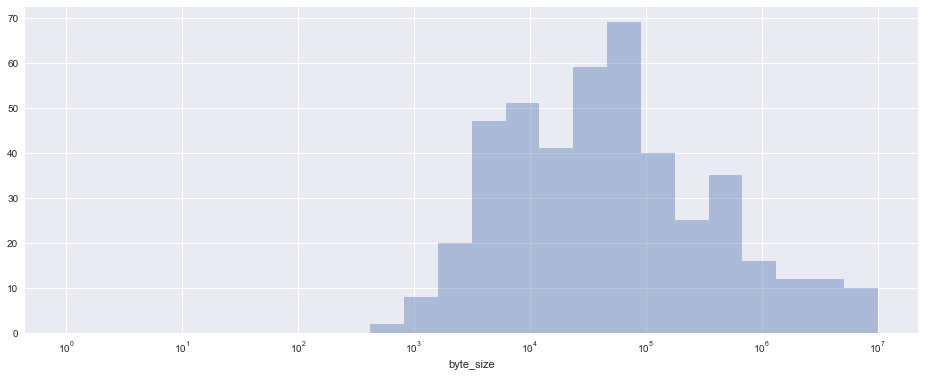

In [26]:
fig1, ax1 = plt.subplots(figsize=(16, 6))
ax1.set_xscale('log')

# sns.distplot(df_clean['byte_size'], bins=np.logspace(0, 7, 50), kde=False, ax = ax1)
sns.distplot(df_no_matplotlib['byte_size'], bins=np.logspace(0, 7, 25), kde=False, ax = ax1)

### Num Cells
Almost all of matplotlib's notebooks are three cells, with the rest distributed around a couple dozen cells or so.

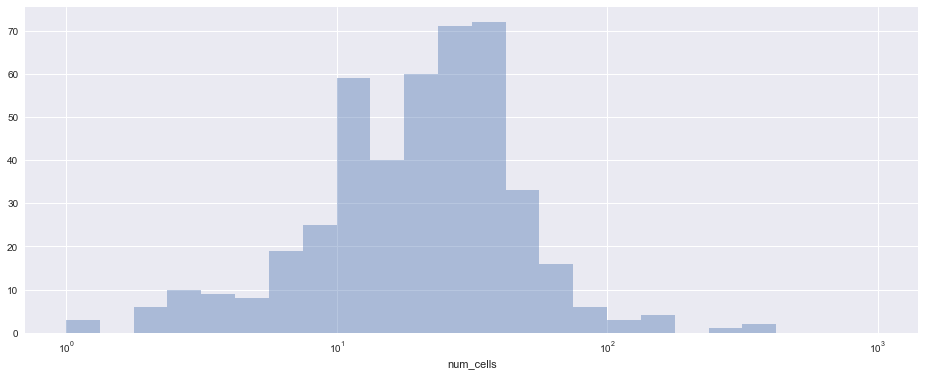

In [25]:
fig2, ax2 = plt.subplots(figsize=(16, 6))
ax2.set_xscale('log')

# sns.distplot(df_clean['num_cells'], bins=np.logspace(0, 3, 50), kde=False, ax = ax2)
sns.distplot(df_no_matplotlib['num_cells'], bins=np.logspace(0, 3, 25), kde=False, ax = ax2)

### Words of Markdown
Here things are a little more interesting. The matplotlib notebooks have a very wide range in the number of words included.

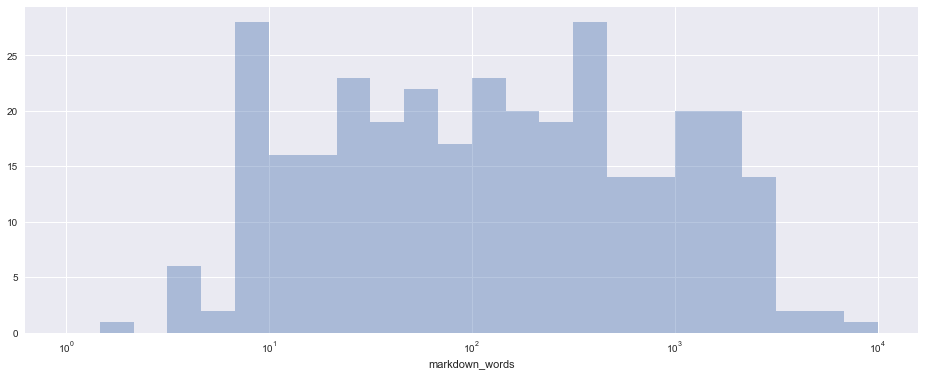

In [24]:
fig3, ax3 = plt.subplots(figsize=(16, 6))
ax3.set_xscale('log')

# sns.distplot(df_clean['markdown_words'], bins=np.logspace(0, 4, 50), kde=False, ax = ax3)
sns.distplot(df_no_matplotlib['markdown_words'], bins=np.logspace(0, 4, 25), kde=False, ax = ax3)

### Lines of Code
Finally, lines of code. Here matplotlib has only 2 lines of code for their files most of the time, quite possibly due to using "\n" chars to differentiate lines. This could be evidence of generating the notebooks programatically.

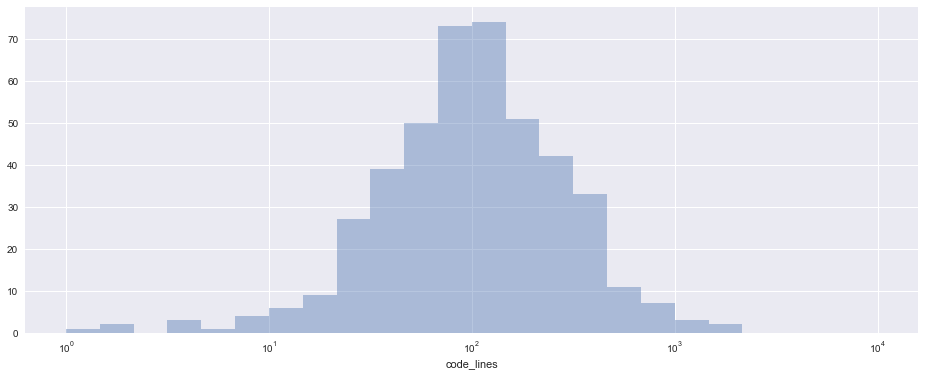

In [23]:
fig4, ax4 = plt.subplots(figsize=(16, 6))
ax4.set_xscale('log')

# ax = sns.distplot(df_clean['code_lines'], bins=np.logspace(0, 4, 50), kde=False, ax = ax4)
ax = sns.distplot(df_no_matplotlib['code_lines'], bins=np.logspace(0, 4, 25), kde=False, ax = ax4)

## Notebook Content
The real interesting part will be analyzing the notebook content. What is in the markd